In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import stats
import yfinance as yf
import seaborn as sns
import warnings

# Suprimir avisos de depreciação
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
# Defina uma taxa de 0,003758% para cada trade alavancado
taxa_trade_margin = 0.00003758
# Defina uma taxa livre de risco (assumindo 3% a.a. para simplificação) NÃO ESTAMOS USANDO ISSO
# taxa_livre_de_risco = 0.000081
#Taxa de corretagem mais slippage médio da binance
taxa_corretagem = 0.001 + 0.0003

#Carregue os dados do arquivo CSV
# Defina o símbolo do título do Tesouro dos EUA de 10 anos
symbol = '^IRX'

# Especifique o intervalo de datas desejado
start_date = '2019-01-08'
end_date = '2023-09-02'

In [3]:
# Função para obter os dados históricos do Tesouro dos EUA
def obter_dados_tesouro(symbol, start_date, end_date):
    risk_free_rate_data = yf.download(symbol, start=start_date, end=end_date)

    # Reindex o DataFrame para incluir todos os dias entre as datas especificadas
    date_range = pd.date_range(start=start_date, end=end_date)
    risk_free_rate_data = risk_free_rate_data.reindex(date_range)

    # Preencha os valores ausentes (finais de semana) com o último valor válido
    risk_free_rate_data.ffill(inplace=True)

    return risk_free_rate_data

risk_free_rate_data = obter_dados_tesouro(symbol, start_date, end_date)

# Função para calcular os retornos diários a partir das taxas anuais
def calcular_retornos_diarios(dataframe):
    dataframe['Daily Return RFR'] = ((1 + dataframe['Adj Close'] / 100) ** (1/365)) - 1
    dataframe['Daily Return RFR'] = dataframe['Daily Return RFR'].round(10)
    return dataframe

calcular_retornos_diarios(risk_free_rate_data)

# Carregue os dados
path = 'Data/bitvol 2019.csv'
df = pd.read_csv(path, sep=';')
df.dropna(axis=0, how='all', inplace=True)
df['IV/MA * 100'] = df['IV/MA * 100'].str.replace(',', '.', regex=True).astype(float)

# Carregue os dados do arquivo CSV
def carregar_dados_csv(path2):
    df2 = pd.read_csv(path2, sep=',')
    df2.dropna(axis=0, how='all', inplace=True)
    return df2
risk_free_rate_data.iloc[0] = risk_free_rate_data.iloc[1]

path2 = 'Data/rf_2019_2022.csv'
df2 = carregar_dados_csv(path2)
# df2 = pd.merge(df2, df, left_on='time', right_on='Data', how='left')
df2 = pd.concat([df2, df[['IV/MA * 100']]], axis=1)


# Converta a coluna 'time' para o tipo de dados datetime
df2['time'] = pd.to_datetime(df2['time'], format='%Y/%m/%d')

df2 = df2.merge(risk_free_rate_data[['Daily Return RFR', 'Adj Close']], left_on='time', right_index=True, how='left')

# Crie DataFrames separados com base nos anos
df_2019_2020 = df2[(df2['time'] >= '2019-01-08') & (df2['time'] <= '2020-12-31')]
df_2019 = df2[(df2['time'] >= '2019-01-08') & (df2['time'] <= '2019-12-31')]
df_2020 = df2[(df2['time'] >= '2020-01-01') & (df2['time'] <= '2020-12-31')]
df_2021 = df2[(df2['time'] >= '2021-01-01') & (df2['time'] <= '2021-12-31')]
df_2022 = df2[(df2['time'] >= '2022-01-01') & (df2['time'] <= '2022-12-31')]
df_2023 = df2[(df2['time'] >= '2023-01-01') & (df2['time'] <= '2023-09-02')]
df_2020_2021 = df2[(df2['time'] >= '2020-01-01') & (df2['time'] <= '2021-12-31')]
df_2021_2022 = df2[(df2['time'] >= '2021-01-01') & (df2['time'] <= '2022-12-31')]
df_2020_2022 = df2[(df2['time'] >= '2020-01-01') & (df2['time'] <= '2022-12-31')]
df_2019_2022 = df2[(df2['time'] >= '2019-01-08') & (df2['time'] <= '2022-12-31')]


df = df_2021_2022

[*********************100%***********************]  1 of 1 completed


In [4]:
# Função para calcular os retornos com base em X, W,  K e J
def calcular_retornos(X, W, K, J, df):
    #lógica de cálculo dos retornos com base em X, W, K e J
    df.loc[:, 'X_adjusted'] = X * (df['IV/MA * 100'] / 100) ** (1/4)
    df.loc[:, 'W_adjusted']  = df['prob_sign_is_1'] * W * 0.1 * df['IV/MA * 100'] / 100   # W é stop loss
#    df.loc[:, 'W_adjusted'] = df['prob_sign_is_1'] * W
#    df.loc[:, 'K_adjusted'] = df['prob_sign_is_1'] * K
    df.loc[:, 'K_adjusted'] = df['prob_sign_is_1'] * K * 0.1 * df['IV/MA * 100'] / 100      # K é take profit
    df.loc[:, 'signal_long'] = (df['prob_sign_is_1'] > df['X_adjusted']).astype(int)
    df.loc[:, 'stop_loss_condition'] = (df['low'].shift(-1) < (1 - df['W_adjusted']) * df['d'])
    df.loc[:, 'take_profit_condition'] = (df['high'].shift(-1) > (1 + df['K_adjusted']) * df['d'])
    df.loc[:, 'montante investido'] = ((((df['prob_sign_is_1']+1)**1.5)-1) * J * (((1 / ((df['IV/MA * 100'])/100)) ** 4) + 0.1)) **1  # ELEVAR A PROBABILIDADE A 2 ou mais
    df.loc[:, 'montante investido anterior'] = df['montante investido'].shift(1)
    df.loc[:, 'signal long anterior'] = df['signal_long'].shift(1)
    df['retorno_diario'] = 0
    condicoes_ativadas = 0  # Para rastrear o número de vezes que as condições foram ativadas n estamos usando tb
    # valor_anterior = 0


    for index, row in df.iterrows():
        if row['signal_long'] == 1:
            if row['stop_loss_condition'] == 0:  # Condição de stop loss não ativada
                if row['take_profit_condition'] == 1:  # Condição de take profit ativada
                    retorno = row['K_adjusted'] - taxa_corretagem
                    condicoes_ativadas += 1
                else:
                    retorno = ((row['d+1_true'] / row['d']) - 1) - taxa_corretagem
            else:  # Condição de stop loss ativada
                if row['take_profit_condition'] == 1:  # Condição de take profit ativada
                    retorno = -row['W_adjusted'] - taxa_corretagem
                    condicoes_ativadas += 1
                else:
                    retorno = -row['W_adjusted'] - taxa_corretagem
        else:
            retorno = row['Daily Return RFR']  # Não há entrada na estratégia neste dia

        #nova condição com base em 'montante investido'
        if row['montante investido'] <= 1:
            retorno = retorno * row['montante investido'] + ((1-row['montante investido']) * row['Daily Return RFR'])
        else:
            retorno *= (row['montante investido'] - ((row['montante investido'] - 1) * taxa_trade_margin))

        if row['signal long anterior'] == 1:
            if row['signal_long'] == 1:
                if row['montante investido anterior'] >= row['montante investido']:
                    retorno += taxa_corretagem
                else:
                    retorno += taxa_corretagem - ((row['montante investido'] - row['montante investido anterior']) * taxa_corretagem)
            else:
                retorno = retorno
        else:
            retorno = retorno
        df.at[index, 'retorno_diario'] = retorno






    #nova coluna para rastrear o número de vezes que as condições foram ativadas
    df.loc[:, 'contagem_condicoes_ativadas'] = condicoes_ativadas

    # Calcular os retornos diários
    df.loc[:, 'retorno_diario_BTC'] = df['d'].pct_change()
    df.loc[0, 'retorno_diario_BTC'] = 0  # Defina o primeiro retorno como 0

    return df


pd.options.mode.chained_assignment = None  # Suppress the warning


# Inicialize dicionários para rastrear os resultados
resultados_sharpe = {}
resultados_roi = {}
resultados_lucro_acumulado = {}
max_drawdown = {}
max_drawdown_btc = {}



# Defina um investimento inicial
investimento_inicial = 1000

# Execute a análise para diferentes valores de X, W e K
valores_X = [0.46] # [0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55]
valores_W = [1.7] #[0.8, 0.85, 0.90, 0.95, 1.00, 1.05, 1.10, 1.15, 1.20, 1.25, 1.30, 1.35, 1.40, 1.45, 1.50, 1.55, 1.60, 1.65, 1.70, 1.75, 1.80, 1.85, 1.90, 1.95, 2.00, 2.05, 2.10, 2.15, 2.20]
valores_K = [1.5] # [0.8, 0.85, 0.90, 0.95, 1.00, 1.05, 1.10, 1.15, 1.20, 1.25, 1.30, 1.35, 1.40, 1.45, 1.50, 1.55, 1.60, 1.65, 1.70, 1.75, 1.80, 1.85, 1.90, 1.95, 2.00, 2.05, 2.10, 2.15, 2.20]
valores_J = [0.75]

# Inicialize listas para armazenar os resultados
X_values = []
W_values = []
K_values = []
J_values = []
Max_Drawdown_values = []
ROI_values = []
Sharpe_values = []
Information_Ratio_values = []

for X in valores_X:
    for W in valores_W:
        for K in valores_K:
          for J in valores_J:
            df = calcular_retornos(X, W, K, J, df)
            # sharpe_ratio = calcular_indice_sharpe(df, risk_free_rate_data)
            #roi = calcular_roi(df, investimento_inicial) IGNORAR

            # Calcule o retorno médio e o desvio padrão dos retornos
            retorno_medio = df['retorno_diario'].mean()
            desvio_padrao_retornos = df['retorno_diario'].std()

            # Calcule o Lucro Acumulado ao Longo do Tempo para a estratégia
            df['lucro_acumulado'] = (df['retorno_diario'] + 1).cumprod() * investimento_inicial
            df['lucro_acumulado_btc'] = (df['retorno_diario_BTC'] + 1).cumprod() * investimento_inicial

            # Quantas vezes stop loss e take profit foram ativados
            stop_loss_true = df['stop_loss_condition'].sum()
            take_profit_true = df['take_profit_condition'].sum()


            #ELIMINANDO AS COLUNAS COM VALORES NAN
            df = df.dropna(subset=['time'])
            colunas_a_preencher = [col for col in df.columns if col not in ['Data', 'time']]
            df[colunas_a_preencher] = df[colunas_a_preencher].fillna(method='ffill').fillna(method='bfill')

            #Calcular o roi
            lucro_total = df['lucro_acumulado'].iloc[-1] - investimento_inicial
            roi = (lucro_total / investimento_inicial) * 100


            # Calcule os retornos diários e médias de retorno
            retorno_medio_btc = df['retorno_diario_BTC'].mean()
            retorno_medio_rfr = df['Daily Return RFR'].mean()

            #Média de alavancagem:
            alavancagem_media =  df['montante investido'].mean()
            maior_alavancagem = df['montante investido'].max()

            # Calcule os excess returns da estratégia e do BTC
            excess_returns_estrategia = (df['retorno_diario'] - df['Daily Return RFR']).tolist()
            excess_returns_btc = (df['retorno_diario_BTC'] - df['Daily Return RFR']).tolist()

            # Calcule o desvio padrão dos retornos em excesso
            desvio_padrao_retornos_em_excesso = np.nanstd(df['retorno_diario'].values - df['Daily Return RFR'].values)
            desvio_padrao_retornos_em_excesso_btc = np.nanstd(df['retorno_diario_BTC'].values - df['Daily Return RFR'].values)

            #Volatilidade Histórica

            dias_volatilidade = 30

            # Passo 2: Calcular a volatilidade realizada
            df['volatilidade_realizada_modelo'] = df['retorno_diario'].rolling(window=dias_volatilidade).std() * 100* np.sqrt(365)
            df['volatilidade_realizada_BTC'] = df['retorno_diario_BTC'].rolling(window=dias_volatilidade).std() * 100 * np.sqrt(365)

            # TESTE Z PARA DIFERENÇA ENTRE MÉDIAS DA VOLATILIDADE REALIZADA.

            media_rv_modelo = df['volatilidade_realizada_modelo'].mean()
            desvio_rv_modelo = df['volatilidade_realizada_modelo'].std()

            media_rv_BTC = df['volatilidade_realizada_BTC'].mean()
            desvio_rv_BTC = df['volatilidade_realizada_BTC'].std()

            # Calcular o tamanho da amostra e o erro padrão da diferença entre as médias.
            n_rv_modelo = len(df['volatilidade_realizada_modelo'])
            n_rv_BTC = len(df['volatilidade_realizada_BTC'])
            erro_padrao_diferenca_rv = np.sqrt((desvio_rv_modelo**2 / n_rv_modelo) + (desvio_rv_BTC**2 / n_rv_BTC))

            # Calcular a estatística Z.
            z_rv = (media_rv_modelo - media_rv_BTC) / erro_padrao_diferenca_rv

            # Calcular o valor p para o teste Z.
            valor_p_rv = 2 * (1 - stats.norm.cdf(abs(z_rv)))

            # Interpretar automaticamente o resultado.
            nivel_significancia = 0.05

            if valor_p_rv < nivel_significancia:
                print("Rejeitar H0: Há uma diferença estatisticamente significativa entre as volatilidades realizadas.")
            else:
                print("Não rejeitar H0: Não há evidência estatística de diferença significativa entre as volatilidades realizadas.")

            print(f"Estatística Z para diff RV = {z_rv:.4f}")
            diff_medias_rv = media_rv_BTC - media_rv_modelo
            print(f"A volatilidade realizada dos últimos 30D, anualizada, do bitcoin tende a ser {diff_medias_rv:.2f}% maior do que a volatilidade realizada do nosso modelo a um P-VALOR de {valor_p_rv:.10f}, isso significa que se a nossa volatilidade em um dia é 30%, a rv do btc no mesmo dia em média é 36%(substituir valor) acima")

            print(f"Volatilidade realizada média estratégia = {media_rv_modelo:.4f}")
            print(f"Volatilidade realizada média BTC = {media_rv_BTC:.4f}")




            # Calcule o Índice de Sharpe
            sharpe_ratio = ((retorno_medio - retorno_medio_rfr) / desvio_padrao_retornos_em_excesso) * (365 ** 0.5)
            sharpe_ratio_btc = ((retorno_medio_btc - retorno_medio_rfr) / desvio_padrao_retornos_em_excesso_btc) * (365 ** 0.5)

            # Calcule o p-valor e faça uma decisão com base no teste Z
            population_variance = np.var(df['retorno_diario'], ddof=0)
            std_pop_estimado = math.sqrt(population_variance)
            alfa = 0.05

            z_statistic = (retorno_medio - retorno_medio_btc) / (std_pop_estimado / math.sqrt(len(df)))
            p_value_z = 2 * (1 - stats.norm.cdf(abs(z_statistic)))

            if abs(z_statistic) > stats.norm.ppf(1 - (alfa / 2)):
                conclusao_z = "Rejeitar a hipótese nula (H0). A estratégia possui vantagem estatisticamente significativa sobre o modelo aleatório (p < 0.05)."
            else:
                conclusao_z = "Não rejeitar a hipótese nula (H0). A estratégia não possui vantagem estatisticamente significativa sobre o modelo aleatório (p >= 0.05)."

            # Exiba os resultados do teste Z
            print(f"Estatística Z: {z_statistic:.4f}")
            print(f"P-valor: {p_value_z:.4f}")
            print(conclusao_z)


            # Calcule o ROI para BTC
            preco_inicial_btc = df['d'].iloc[0]
            preco_final_btc = df['d'].iloc[-1]
            ganho_liquido_btc = (preco_final_btc - preco_inicial_btc) * (investimento_inicial / preco_inicial_btc)
            roi_btc = (ganho_liquido_btc / investimento_inicial) * 100

            #Max drawdown

            window = len(df)

            # Calculate the maximum drawdown for the entire time period
            Roll_Max = df['lucro_acumulado'].rolling(window, min_periods=1).max()
            Daily_Drawdown = df['lucro_acumulado'] / Roll_Max - 1.0
            # Calculate the overall maximum drawdown
            max_drawdown = Daily_Drawdown.min()

            #Cálculo do Information Ratio

            excess_returns_vsbtc = df['retorno_diario'] - df['retorno_diario_BTC']
            desvio_padrao_excess_returns_vsbtc = np.nanstd(excess_returns_vsbtc)
            tracking_error = desvio_padrao_excess_returns_vsbtc
            information_ratio = np.sqrt(365) * (retorno_medio - retorno_medio_btc) / tracking_error


            # Calculate the maximum drawdown for the entire time period
            Roll_Max_btc = df['lucro_acumulado_btc'].rolling(window, min_periods=1).max()
            Daily_Drawdown_btc = df['lucro_acumulado_btc'] / Roll_Max_btc - 1.0
            # Calculate the overall maximum drawdown
            max_drawdown_btc = Daily_Drawdown_btc.min()

            #Gráfico dos drawdowns

            # Calcular drawdowns para 'lucro_acumulado'
            Roll_Max = df['lucro_acumulado'].rolling(window, min_periods=1).max()
            Daily_Drawdown = df['lucro_acumulado'] / Roll_Max - 1.0
            drawdowns_portfolio = Daily_Drawdown.to_list()


            # Calcular drawdowns para 'lucro_acumulado_btc'
            Roll_Max_btc = df['lucro_acumulado_btc'].rolling(window, min_periods=1).max()
            Daily_Drawdown_btc = df['lucro_acumulado_btc'] / Roll_Max_btc - 1.0
            drawdowns_btc = Daily_Drawdown_btc.to_list()

            #Teste Z para diferença entre os drawdowns.

            # Calcular as médias e desvios-padrão das duas séries.
            media_drawdown_dd = np.mean(Daily_Drawdown)
            desvio_drawdown_dd = np.std(Daily_Drawdown)

            media_drawdown_btc_dd = np.mean(Daily_Drawdown_btc)
            desvio_drawdown_btc_dd = np.std(Daily_Drawdown_btc)

            # Calcular o tamanho das amostras.
            n_drawdown_dd = len(Daily_Drawdown)
            n_drawdown_btc_dd = len(Daily_Drawdown_btc)

            # Calcular o erro padrão da diferença entre as médias.
            erro_padrao_diferenca_dd = np.sqrt((desvio_drawdown_dd**2 / n_drawdown_dd) + (desvio_drawdown_btc_dd**2 / n_drawdown_btc_dd))

            # Calcular a estatística Z.
            z_dd = (media_drawdown_dd - media_drawdown_btc_dd) / erro_padrao_diferenca_dd

            # Calcular o valor p para o teste Z.
            valor_p_dd = 2 * (1 - stats.norm.cdf(abs(z_dd)))

            # Interpretar automaticamente o resultado.

            if valor_p_dd < nivel_significancia:
                resultado_dd = "Rejeitar H0: Há uma diferença estatisticamente significativa entre as médias dos DRAWDOWNS."
            else:
                resultado_dd = "Não rejeitar H0: Não há evidência estatística de diferença significativa entre as médias dos DRAWDOWNS."

            # Imprimir o resultado.
            print(resultado_dd)

            print(f"Estatística Z para diff DRAWDOWNS = {z_dd:.4f}")
            diff_medias_drawdowns = -(media_drawdown_btc_dd - media_drawdown_dd) * 100
            print(f"O drawdown médio do BTC é {diff_medias_drawdowns:.2f}% maior em relação ao ATH do que o drawdown médio do nosso modelo a um P-VALOR de {valor_p_dd:.4f}, isso significa que se o nosso modelo caiu 25% em relação ao ATH, o BTC caiu em média 50%")
            print(f"Drawdown médio estratégia = {media_drawdown_dd:.4f}")
            print(f"Drawdown médio BTC = {media_drawdown_btc_dd:.4f}")

            # Armazene os resultados em dicionários usando X, W e K como chaves
            resultados_sharpe[(X, W, K)] = sharpe_ratio
            resultados_roi[(X, W, K)] = roi
            resultados_lucro_acumulado[(X, W, K)] = df['lucro_acumulado'].tolist()

            #Média de trades no mês e Holding period

            # Crie uma cópia da coluna signal_long e converta-a em int
            df['signal_copy'] = df['signal_long'].astype(int)

            # Encontre os grupos de valores 1 consecutivos
            df['group'] = (df['signal_copy'] != df['signal_copy'].shift()).cumsum()

            # Identifique os grupos que têm um 1 isolado entre 0s
            isolated_ones = df.groupby('group')['signal_copy'].transform('sum') == 1

            # Crie uma nova coluna para calcular a soma considerando apenas 1 para grupos de 1s consecutivos e 1s isolados
            df['sum_result'] = (df['signal_copy'] & (df['signal_copy'].shift(-1).fillna(0).astype(int) | isolated_ones.astype(int)))

            # Calcule a soma final
            final_sum1 = df['sum_result'].sum()
            final_sum = final_sum1/len(df)*30

            dias_operando = df['signal_long'].sum()

            average_ones = dias_operando/final_sum1

            print("O holding period médio é:", average_ones)
            print(f"O número de trades mensais em média é = {final_sum}")
            print(f" Informatio Ratio  = {information_ratio}")
            print(f" Num de vezes stop loss ativado  = {stop_loss_true}")
            print(f" Num de vezes take profit ativado  = {take_profit_true}")
            print(f" alavancagem media  = {alavancagem_media}")
            print(f" alavancagem máxima  = {maior_alavancagem}")
            print(f"max drawdown BTC = {max_drawdown_btc}")
            print(f"max drawdown = {max_drawdown}")
            print(f"std pop estimado = {std_pop_estimado}")
            print(f"math sqrt len df = {math.sqrt(len(df))}")
            print(f"sharpe_ratio = {sharpe_ratio}")
            print(f"roi = {roi}")
            print(f"'X = {X}',' W = {W}',' K = {K}',{roi}")
            print(f"retorno_medio = {retorno_medio}")
            print(f"desvio_padrao_retornos = {desvio_padrao_retornos}")
            print(f"lucro_acumulado = {df['lucro_acumulado']}")
            print(f"retorno_medio_btc = {retorno_medio_btc}")
            print(f"retorno_medio_rfr = {retorno_medio_rfr}")
            # print(f"excess_returns_estrategia = {excess_returns_estrategia}")
            # print(f"excess_returns_btc = {excess_returns_btc}")
            print(f"desvio_padrao_retornos_em_excesso = {desvio_padrao_retornos_em_excesso}")
            print(f"desvio_padrao_retornos_em_excesso_btc = {desvio_padrao_retornos_em_excesso_btc}")
            print(f"sharpe_ratio = {sharpe_ratio}")
            print(f"sharpe_ratio_btc = {sharpe_ratio_btc}")
            print(f"ganho_liquido_btc = {ganho_liquido_btc}")
            print(f"roi_btc = {roi_btc:.2f}%")

            # Exiba os resultados
            print("Resultados do Índice de Sharpe e ROI para diferentes valores de X, W e K com Take Profit:")
            print(f"X = {X}, W = {W}, K = {K}: Índice de Sharpe estratégia = {sharpe_ratio:.4f}, Sharpe BTC BUY and HOLD: {sharpe_ratio_btc:.4f}, ROI Estratégia = {roi:.2f}%, ROI BTC = {roi_btc:.2f}%")


            # Adicione os resultados nas listas
            X_values.append(X)
            W_values.append(W)
            K_values.append(K)
            J_values.append(J)
            Max_Drawdown_values.append(max_drawdown)
            ROI_values.append(roi)
            Sharpe_values.append(sharpe_ratio)
            Information_Ratio_values.append(information_ratio)

Rejeitar H0: Há uma diferença estatisticamente significativa entre as volatilidades realizadas.
Estatística Z para diff RV = -30.3762
A volatilidade realizada dos últimos 30D, anualizada, do bitcoin tende a ser 31.67% maior do que a volatilidade realizada do nosso modelo a um P-VALOR de 0.0000000000, isso significa que se a nossa volatilidade em um dia é 30%, a rv do btc no mesmo dia em média é 36%(substituir valor) acima
Volatilidade realizada média estratégia = 38.5154
Volatilidade realizada média BTC = 70.1824
Estatística Z: 1.5408
P-valor: 0.1234
Não rejeitar a hipótese nula (H0). A estratégia não possui vantagem estatisticamente significativa sobre o modelo aleatório (p >= 0.05).
Rejeitar H0: Há uma diferença estatisticamente significativa entre as médias dos DRAWDOWNS.
Estatística Z para diff DRAWDOWNS = 23.0734
O drawdown médio do BTC é 24.57% maior em relação ao ATH do que o drawdown médio do nosso modelo a um P-VALOR de 0.0000, isso significa que se o nosso modelo caiu 25% em 

In [7]:
# Crie um DataFrame com os resultados
data_saida = {
    "X": X_values,
    "W": W_values,
    "K": K_values,
    "Max Drawdown": Max_Drawdown_values,
    "ROI": ROI_values,
    "Sharpe": Sharpe_values,
    "Information Ratio": Information_Ratio_values
}
df_resultados = pd.DataFrame(data_saida)
print(df_resultados)
# Salve o DataFrame em um arquivo Excel
df_resultados.to_excel("resultados 2019-2020 finais apresentaçao.xlsx", index=False)
# files.download('resultados 2019-2020 finais apresentaçao.xlsx')

      X    W    K  Max Drawdown        ROI    Sharpe  Information Ratio
0  0.46  1.7  1.5     -0.506985  96.320217  0.953759           0.561514


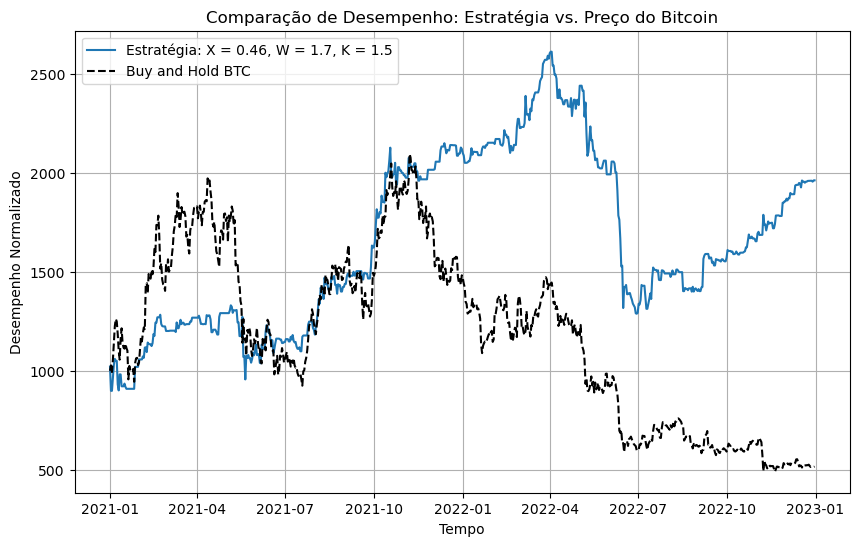

--------------------------------------------


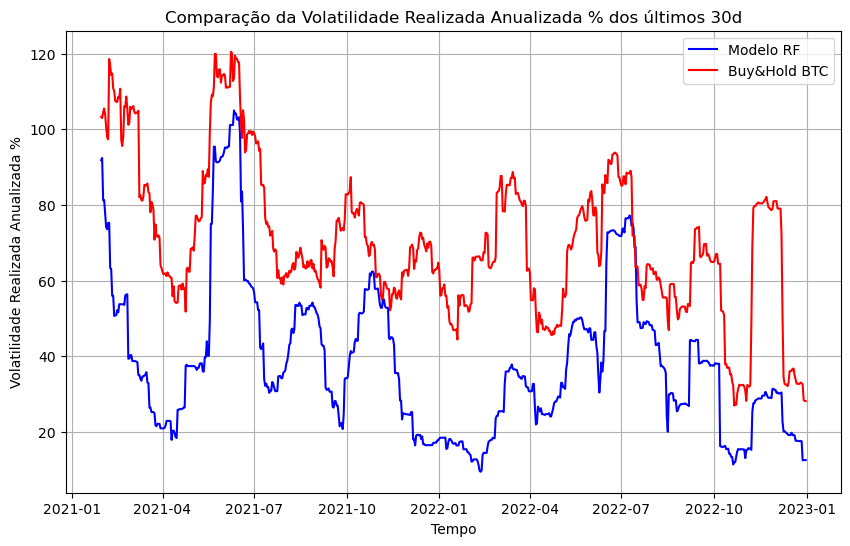

      lucro_acumulado  lucro_acumulado_btc  volatilidade_realizada_modelo  \
731       1020.828963          1027.355522                            NaN   
732        898.578057          1027.355522                            NaN   
733        898.579657           993.461431                            NaN   
734        964.339674          1056.570959                            NaN   
735       1030.476142          1143.820889                            NaN   
...               ...                  ...                            ...   
1456      1961.053789           513.401040                      17.568872   
1457      1961.281958           516.132557                      12.498878   
1458      1956.610989           515.356558                      12.575580   
1459      1962.977794           513.028560                      12.566233   
1460      1963.202165           515.729037                      12.566202   

      volatilidade_realizada_BTC  Drawdowns Portfolio  Drawdowns BTC  
731 

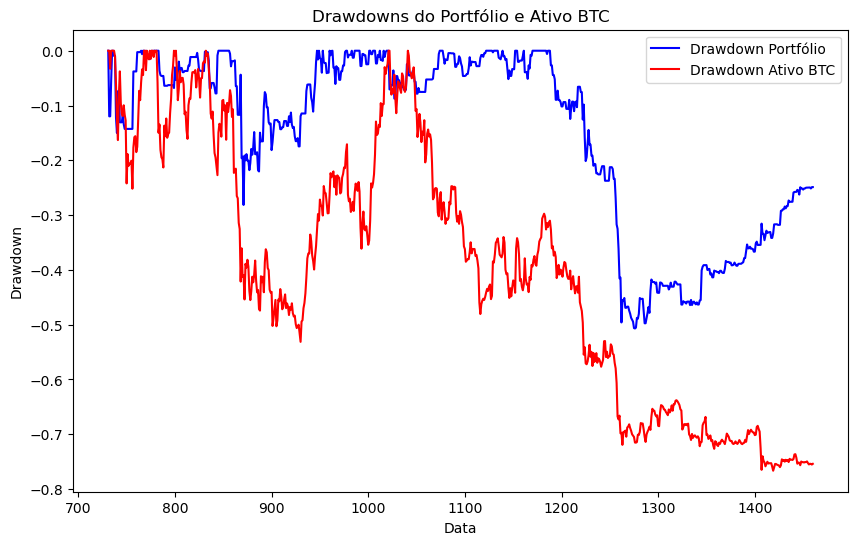

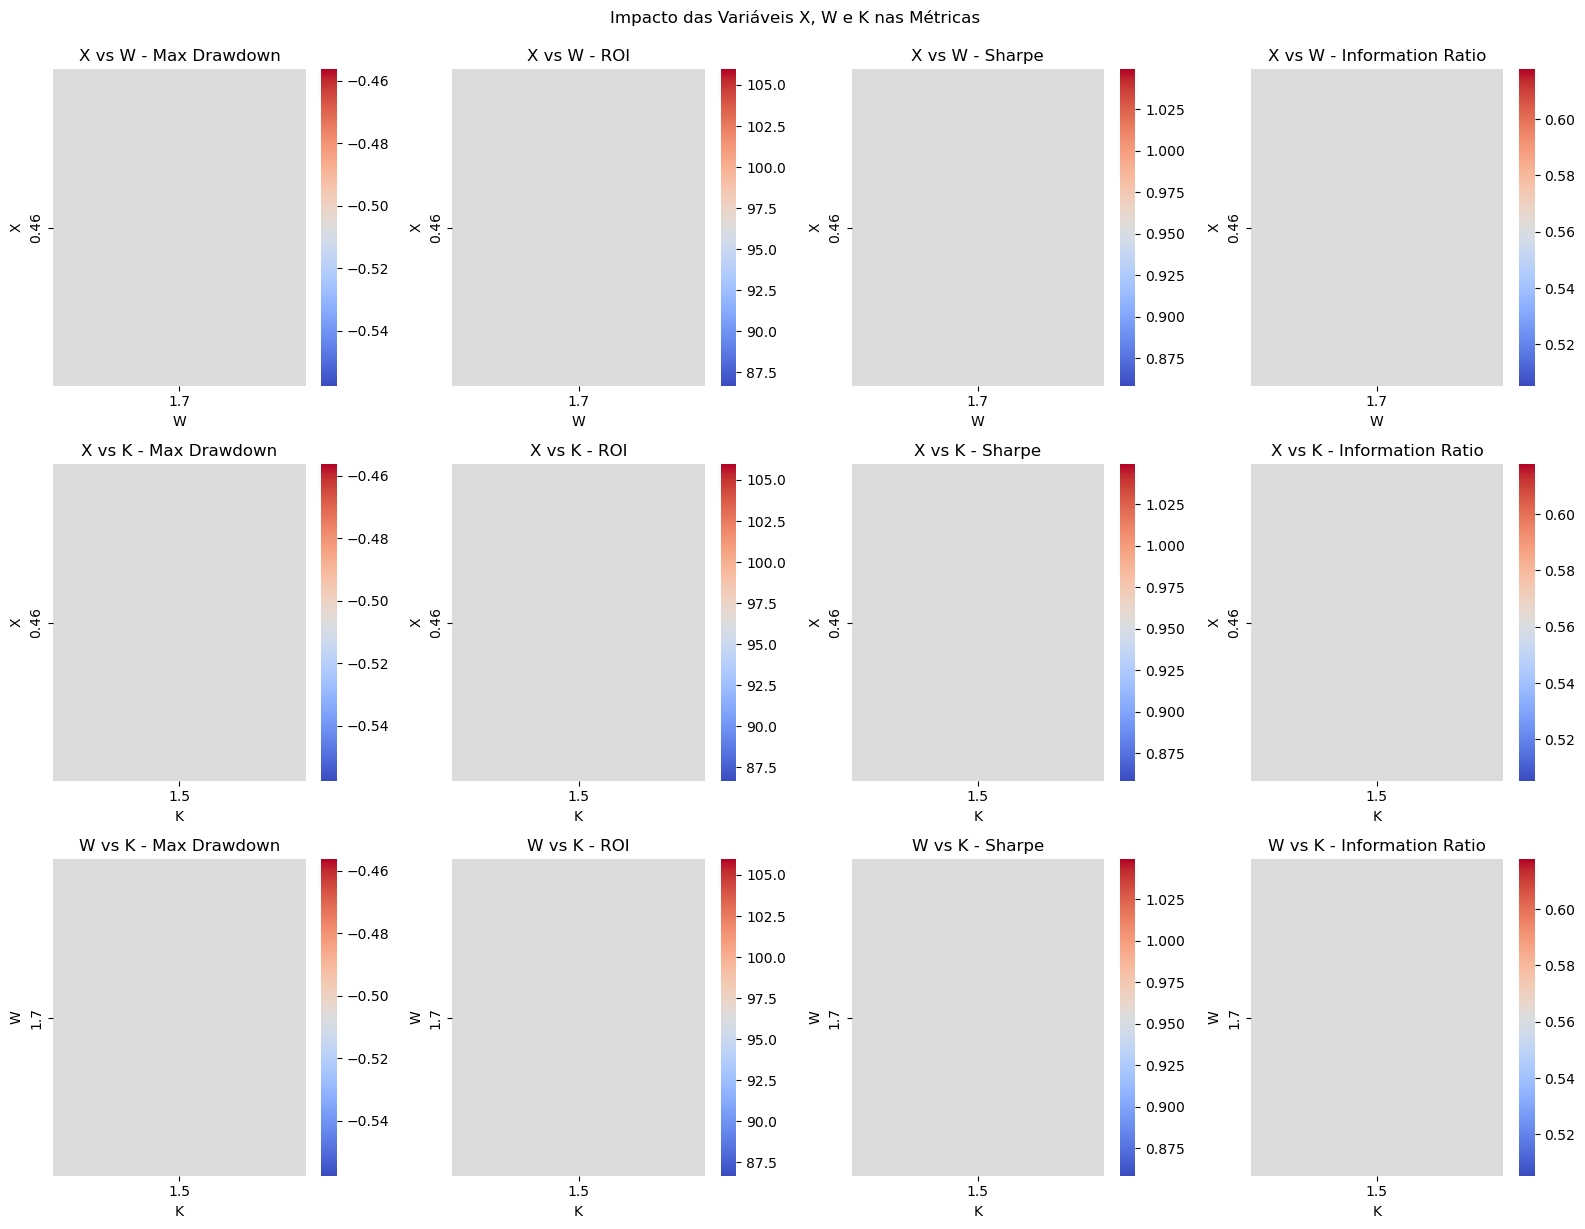

In [8]:

#Plotando o Lucro Acumulado da estratégia do modelo e o preço do Bitcoin no mesmo gráfico
plt.figure(figsize=(10, 6))
for (X, W, K), lucro_acumulado in resultados_lucro_acumulado.items():
   plt.plot(df['time'], lucro_acumulado, label=f'Estratégia: X = {X}, W = {W}, K = {K}')
plt.plot(df['time'], df['d'] / df['d'].iloc[0] * investimento_inicial, label='Buy and Hold BTC', linestyle='--', color='black')
plt.xlabel('Tempo')
plt.ylabel('Desempenho Normalizado')
plt.title('Comparação de Desempenho: Estratégia vs. Preço do Bitcoin')
plt.legend()
plt.grid(True)
plt.show()
print('--------------------------------------------')


# Crie um gráfico de linha para comparar a volatilidade realizada ao longo do tempo
plt.figure(figsize=(10, 6))
plt.plot(df['time'], df['volatilidade_realizada_modelo'], label='Modelo RF', color='blue')
plt.plot(df['time'], df['volatilidade_realizada_BTC'], label='Buy&Hold BTC', color='red')
plt.xlabel('Tempo')
plt.ylabel('Volatilidade Realizada Anualizada %')
plt.title('Comparação da Volatilidade Realizada Anualizada % dos últimos 30d')
plt.legend()
plt.grid(True)
plt.show()

df['Drawdowns Portfolio'] = drawdowns_portfolio
df['Drawdowns BTC'] = drawdowns_btc

colunas_sasa = ['lucro_acumulado', 'lucro_acumulado_btc', 'volatilidade_realizada_modelo', 'volatilidade_realizada_BTC', 'Drawdowns Portfolio', 'Drawdowns BTC']
df_sasa = df[colunas_sasa]
print(df_sasa)
df_sasa.to_csv("resultados finais 2021-2022.csv", index=False)
# files.download('resultados finais 2021-2022.csv')

# Configurar o tamanho do gráfico
plt.figure(figsize=(10, 6))

# Plotar drawdowns para 'lucro_acumulado'
plt.plot(df.index, drawdowns_portfolio, label='Drawdown Portfólio', color='blue')

# Plotar drawdowns para 'lucro_acumulado_btc'
plt.plot(df.index, drawdowns_btc, label='Drawdown Ativo BTC', color='red')

# Configurar rótulos e legenda
plt.xlabel('Data')
plt.ylabel('Drawdown')
plt.title('Drawdowns do Portfólio e Ativo BTC')
plt.legend()

# Mostrar o gráfico
plt.show()

df = df_resultados

# Crie uma lista de pares de variáveis para as combinações desejadas.
combinations = [("X", "W"), ("X", "K"), ("W", "K")]

# Configure o número de colunas e linhas para a figura.
num_rows = 3
num_cols = 4

# Crie a figura e os eixos para os heatmaps.
fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 12))

# Crie uma lista de nomes das métricas para os títulos dos heatmaps.
metrics = ["Max Drawdown", "ROI", "Sharpe", "Information Ratio"]

# Loop para criar os heatmaps.
for i, (var1, var2) in enumerate(combinations):
    for j, metric in enumerate(metrics):
        ax = axes[i][j]
        sns.heatmap(df.pivot_table(index=var1, columns=var2, values=metric, aggfunc="mean"), annot=False, fmt=".2f", cmap="coolwarm", cbar=True, ax=ax)
        ax.set_title(f"{var1} vs {var2} - {metric}")

# Ajuste os espaçamentos entre os subplots e adicione um título.
plt.tight_layout()
plt.suptitle("Impacto das Variáveis X, W e K nas Métricas", y=1.02)

# Exiba a figura.
plt.show()